In [27]:
import array

import ahocorasick
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt

%matplotlib notebook

In [77]:
comments = pd.read_csv("../data/all_comments.csv", index_col=0)
posts = pd.read_csv("../data/all_posts.csv", index_col=0)

/Users/naitian/Documents/Projects/MDST/rateme/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
comments.body = comments.body.fillna("")
comments = comments[comments.clean_link_id.isin(set(posts.index))]

In [180]:
from collections import defaultdict
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer


def get_phrases(phrase_file, min_count=0):
#     vocab = {}
    i = 0
    vocab = ahocorasick.Automaton()
    phrases = []
    with open(phrase_file, "r") as file:
        for line in file:
            phrase, count = line.split("\t")
            if int(count) >= min_count:
                vocab.add_word(phrase, i)
                phrases.append(phrase)
                i += 1
    vocab.make_automaton()
    return vocab, phrases

def read_vocab(corpus_file, min_count=5):
    corpus = []
    phrase_count = defaultdict(int)
    phrases_idx = dict()
    i = 0
    with open(corpus_file, "r") as file:
        for line in file:
            phrases = line.strip().split(",")
            for phrase in phrases:
                if phrase not in phrases_idx:
                    phrase_count[phrase] += 1
                    if phrase_count[phrase] >= min_count:
                        phrases_idx[phrase] = i
                        i += 1
            corpus.append(phrases)
        return corpus, phrases_idx

def read_posts(corpus_file, data_file):
    posts = pd.read_csv(data_file, index_col=0)
    id_to_post_map = dict()
    with open(corpus_file, "r") as file:
        for line, p_id in zip(file, posts.index):
            phrases = line.strip().split(",")
            id_to_post_map[p_id] = phrases
    return id_to_post_map

def naive_tokenize(corpus, idx_map):
    X = np.zeros((len(corpus), len(idx_map)))
    for i, phrases in enumerate(corpus):
        for phrase in phrases:
            try:
                X[i][idx_map[phrase]] += 1
            except KeyError:
                continue
    return X

def tokenize_from_series(df, df_index, idx_map):
    indices = []
    indptr = [0]
    data = array.array(str("i"))
    for i, index in enumerate(df_index):
        if i % 100000 == 0:
            print(i)
        doc = df.loc[index]
        feature_idx_map = defaultdict(int)
        try:
            for phrase, idx in vocab.iter(doc):
                try:
                    feature_idx_map[idx] += 1
                except KeyError:
                    continue
                except Exception as e:
                    print(doc)
                    raise e
        except Exception as e:
            print(doc)
            raise e
        indices.extend(feature_idx_map.keys())
        data.extend(feature_idx_map.values())
        indptr.append(len(indices))
        
    indices = np.asarray(indices, dtype=np.int64)
    indptr = np.asarray(indptr, dtype=np.int64)
    data = np.frombuffer(data, dtype=np.intc)

    X = csr_matrix((data, indices, indptr),
                    shape=(len(indptr) - 1, len(idx_map)),
                    dtype=np.int32)
    return X

def tokenize(corpus, idx_map):
    indices = []
    indptr = [0]
    data = array.array(str("i"))
    for i, phrases in enumerate(corpus):
        if i % 1000 == 0:
            print(i)
        feature_idx_map = defaultdict(int)
        for phrase in phrases:
            try:
                idx = idx_map[phrase]
                feature_idx_map[idx] += 1
            except KeyError:
                continue
        indices.extend(feature_idx_map.keys())
        data.extend(feature_idx_map.values())
        indptr.append(len(indices))
        
    indices = np.asarray(indices, dtype=np.int64)
    indptr = np.asarray(indptr, dtype=np.int64)
    data = np.frombuffer(data, dtype=np.intc)

    X = csr_matrix((data, indices, indptr),
                    shape=(len(indptr) - 1, len(idx_map)),
                    dtype=np.int32)
    return X

tfidf = TfidfTransformer()

In [111]:
vocab, c_phrases = get_phrases("../data/phrases_comments.txt")
print(len(vocab))
tokens = tokenize_from_series(comments.body, comments.index, vocab)
comment_vectors = tfidf.fit(tokens).transform(tokens)

12957
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [112]:
vocab, p_phrases = get_phrases("../data/phrases_posts.txt")
tokens = tokenize_from_series(posts.title, comments.clean_link_id, vocab)
post_vectors = tfidf.fit(tokens).transform(tokens)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [90]:
from scipy.sparse import linalg

In [113]:
U, Sigma, V_T = linalg.svds(comment_vectors.transpose(), k=50)

In [92]:
V_T.

(1710540, 12957)

In [100]:
(post_vectors.transpose() * V_T.transpose() * (1 / Sigma)).shape

(12957, 50)

In [114]:
phrases_in_latent_space = (post_vectors.transpose() * V_T.transpose() * (1 / Sigma))

In [188]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20)
labels = kmeans.fit_predict(phrases_in_latent_space)

In [192]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([  20, 1843,    1,    1,    1,    1,    5,    1,    2,    4,   10,
           3,   77,    1,    1,    1,  305,   12,    2,   23]))

In [191]:
for label in np.unique(labels):
    print(np.array(v_phrases)[labels == label])

['growing my hair' 'shaved my head' 'long or short hair'
 'short or long hair' 'longer hair' 'hair or long' 'hair length'
 'Short hair or long hair' 'shorter hair' 'long hair or short'
 'chopped my hair' 'recently cut my hair' 'hair or short' 'long or short'
 'short or long' 'pixie cut' 'Short hair or long' 'recently cut'
 'hair or short hair' 'hair or long hair']
['lost lbs' 'https   imgur' 'http   imgur' ...
 'lost about  pounds  so I ve' 'advice is appreciated    have a great'
 'Curious how I m viewed to people']
['honest opinions']
['honest rating']
['long hair']
['hair color']
['losing weight' 'weight loss' 'Recently lost' 've lost' 'lot of weight']
['facial hair']
['constructive criticism' 'st time']
['big nose' 'hate my nose' 'insecure about my nose'
 'conscious about my nose']
['Rate me honestly' 'curious what people' 'Rate my face' 'brutal honesty'
 'wondering where I stand' 'low self esteem' 've been told' 'months ago'
 'improve my appearance' 'st pic']
['brutally honest' 'ho

In [183]:
comments[labels == 10].body

ValueError: Item wrong length 2314 instead of 1710540.

In [183]:
from sklearn.cluster import KMeans

k = []
scores = []
models = []
for i in range(5, 25):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(U
    k.append(i)
    scores.append(kmeans.score(V_T))
    print(k[-1])
    print(scores[-1])
    models.append(kmeans)

5
-46.028562853087294
6
-45.04990211021772
7
-44.07115425060971
8
-43.07751394031114
9
-42.128830587121584
10
-41.18767182813366
11
-40.23865840562574
12
-39.290364199009595
13
-38.2757569028726
14
-37.35936666447411
15
-36.37540518346881
16
-35.452562755410135
17
-34.485372818072264
18
-33.51173266768564
19
-32.550959565772395
20
-31.608989378560263
21
-30.667570615721303
22
-29.699075764424325
23
-28.728578005312656
24
-27.814601370338508


In [110]:
posts.shape

(218000, 11)

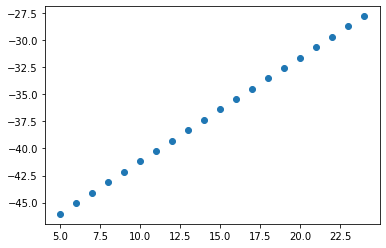

In [188]:
plt.figure()
plt.scatter(k, scores)
plt.show()

In [174]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([211419,    365,    257,    456,    321,    186,    677,    206,
           376,    342,    631,    181,    192,    257,    233,    214,
           206,    245,    172,   1064]))

In [182]:
posts[labels == 19].title

ValueError: Item wrong length 2314 instead of 217586.